# Support Vector Machine Predictive Model for EDTA QC Evaluation: Part 1 – Model Building

We will build a **Support Vector Machine** (SVM) classifier using **scikit-learn**. Two datasets (training and testing) containing experimental data from healthy donors (described in the current manuscript: https://............) are used for model development.


Contents:
- **Data Preprocessing Before Loading**

- **Module Imports**

- **Importing and Preprocessing Training and Validation data**
    - Importing data
    - Splitting data into independent and dependent variables
    - Splitting into training and validation sets (80/20)
    - Scaling for plots only and PCA Scree plot  
    - PCA Scree plot with all principal components
    - PCA plots with 2 principal components

- ** SVM with RBF kernel**
    - RBF kernel: PCA transformation and ROC curves 
    - RBF kernel: Validation curves (check for overfitting) 
    - RBF kernel: Selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)
    - RBF kernel: Support vectors
    - RBF kernel: Visualisation of the decision boundary using 2D PCA

- ** SVM with Polynomial kernel** 
    - Polynomial kernel: PCA transformation and ROC
    - Polynomial kernel: Validation curves (check for overfitting) 
    - Polynomial kernel: Selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)
    - Polynomial kernel: Support vectors
    - Polynomial kernel: Visualisation of the decision boundary using the two PCs  

 - **Building the Final SVM pipeline**
    - Selection of the best kernel for SVM
    - Final model refitting on the full training set (without 23 holdouts)
    - Final support vectors
    - Summary for final model training and saving as joblib

#  Part 2 –  Model Testing
    - Reloading the saved final model from joblib
    - Data preprocessing - Train197, Test1 and Test2
    - Test1 and Test2 predictions
    - Visualisation of decision function scores for test samples
    - Setting of the "safe" threshold
    - Visualisation of the safe threshold

----
----

#### **Data Preprocessing Before Loading**

The first step is to clean the data.
- Any samples with missing data were excluded. 
- Data were normalized using three reference genes: GAPDH, GUSB, and PPIB (sequences of optimized primers can be found at https://pubmed.ncbi.nlm.nih.gov/25369468/).
- Data were checked for outliers, which were excluded (no outliers are allowed in the training data). 
- In Genex Enterprise (MultiD), SOM analysis identified clean two classes in the training set after removing outliers.

----
----

#### **Module Import**

In [117]:
import os
import joblib
from joblib import load
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, balanced_accuracy_score, auc, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
from IPython.display import display
from datetime import datetime
from glob import glob
import ipywidgets as widgets
from IPython.display import display

In [118]:
def plot_validation_curve(
    estimator,
    X, y,
    param_name,
    param_range,
    *,
    cv,
    scoring,
    xscale="log",          
    title=None,
    ylim=None,
    legend_loc="best",
    n_jobs=-1,
    show=True
    ):
    
    train_scores, val_scores = validation_curve(
        estimator=estimator,
        X=X, y=y,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs
    )

    tr_mean, tr_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    va_mean, va_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure(figsize=(7, 5))
    plt.plot(param_range, tr_mean, marker="o", label="Training (mean)")
    plt.fill_between(param_range, tr_mean - tr_std, tr_mean + tr_std, alpha=0.2)
    plt.plot(param_range, va_mean, marker="s", label="Validation (mean)")
    plt.fill_between(param_range, va_mean - va_std, va_mean + va_std, alpha=0.2)

    try:
        if xscale and np.all([np.isscalar(v) and isinstance(v, (int, float, np.number)) for v in param_range]):
            plt.xscale(xscale)
        else:
            print(f"Warning: param_range for '{param_name}' is not numeric — skipping xscale='{xscale}'")
    except Exception as e:
        print(f"Could not set xscale: {e}")

    plt.xlabel(param_name)
    plt.ylabel(f"{scoring} (CV)")
    if title:
        plt.title(title)
    else:
        plt.title(f"Validation curve — {param_name}")

    if ylim is not None:
        plt.ylim(*ylim)

    plt.grid(True)
    plt.legend(loc=legend_loc)
    if show:
        plt.show()

    print("🔍 Mean training scores:", tr_mean.round(2))
    print("🔍 Mean validation scores:", va_mean.round(2))
    print("📉 Differences (train - val):", (tr_mean - va_mean).round(2))

    best_val_idx = np.argmax(va_mean)
    min_diff_idx = np.argmin(np.abs(tr_mean - va_mean))

    print(f"Best {param_name} by validation score: {param_range[best_val_idx]} — score = {va_mean[best_val_idx]:.2f}")
    print(f"Most balanced {param_name} (train - val): {param_range[min_diff_idx]} — diff = {(tr_mean[min_diff_idx] - va_mean[min_diff_idx]):.2f}")


    return {
        "train_scores": train_scores,
        "val_scores": val_scores,
        "train_mean": tr_mean,
        "val_mean": va_mean,
        "train_std": tr_std,
        "val_std": va_std,
    }


In [119]:
# ── Setup paths relative to project root ──
cwd = Path().cwd()
ROOT = cwd
while not (ROOT / "README.md").exists():
    ROOT = ROOT.parent

DATA_DIR = ROOT / "data"
MODELS_DIR = ROOT / "models"
NB_OUTPUT = ROOT / "notebooks" / "outputs_from_notebooks"
VERSIONS_DIR = MODELS_DIR / "versions"

# Create folders if needed
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
NB_OUTPUT.mkdir(parents=True, exist_ok=True)
VERSIONS_DIR.mkdir(parents=True, exist_ok=True)

# Paths to data
DEV_DATA_PATH = DATA_DIR / "train_197_data.csv"
TEST1_PATH = DATA_DIR / "test1_data.csv"
TEST2_PATH = DATA_DIR / "test2_data.csv"

MODEL_PATH = MODELS_DIR / "final_pipeline_prob_v3_2025-09-05.joblib" # for manual changing

print("ROOT:", ROOT)
print("DEV_DATA_PATH:", DEV_DATA_PATH, "Exists?", DEV_DATA_PATH.exists())
print("TEST1_PATH:", TEST1_PATH, "Exists?", TEST1_PATH.exists())
print("TEST2_PATH:", TEST2_PATH, "Exists?", TEST2_PATH.exists())
print("MODEL_PATH:", MODEL_PATH, "Exists?", MODEL_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\train_197_data.csv Exists? True
TEST1_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\test1_data.csv Exists? True
TEST2_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\test2_data.csv Exists? True
MODEL_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\final_pipeline_prob_v3_2025-09-05.joblib Exists? True


In [120]:
# ── Visualization settings (colors, markers) ──
COLORS = {
    "train_0": "#fb9a99",
    "train_1": "#a6cee3",
    "val_0": "#e31a1c",
    "val_1": "#1f78b4"
}

MARKERS = {
    "train": "o",
    "val": "^"
}

POINT_SIZES = {
    "train": 80,
    "val": 100
}


#### Directory Structure Overview (optional)

This cell prints the folder and file structure of the current working directory using `os.walk()`.
It is useful for debugging or verifying that all necessary files are in place.  

In [121]:

for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.path.sep, "/").count("/")
    indent = " " * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

./
    1_SVM_model_training_testing_10092025.ipynb
    2_SVM_decision_boundary_10092025.ipynb
    outputs_from_notebooks/
        220svm_test_predictions.xlsx
        220unknown_predictions_FNR0.csv
        220unknown_predictions_FNR1.csv
        220unknown_predictions_FNR10.csv
        220unknown_predictions_FNR2.csv
        220unknown_predictions_FNR3.csv
        220unknown_predictions_FNR4.csv
        220unknown_predictions_FNR5.csv
        220unknown_predictions_FNR6.csv
        220unknown_predictions_FNR7.csv
        220unknown_predictions_FNR8.csv
        220unknown_predictions_FNR9.csv
        final_pipeline_prob.joblib
        svm_val_predictions.xlsx
        unknown_predictions_FNR0.csv
        unknown_predictions_FNR1.csv
        unknown_predictions_FNR10.csv
        unknown_predictions_FNR2.csv
        unknown_predictions_FNR3.csv
        unknown_predictions_FNR4.csv
        unknown_predictions_FNR5.csv
        unknown_predictions_FNR6.csv
        unknown_predictions_FNR7.cs

In [122]:
print("ROOT:", ROOT)
print("DEV_DATA_PATH:", DEV_DATA_PATH)
print("Exists?", DEV_DATA_PATH.exists())

ROOT: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce
DEV_DATA_PATH: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\data\train_197_data.csv
Exists? True


----
----

#### **Importing and Preprocessing Training and Validation data**

In this section, we will work with the development dataset (197 samples). 
This dataset will be split into training (80%) and validation (20%) subsets. 
All preprocessing (scaling, PCA) and model selection will be carried out on this development set.

#### Task 1: Importing data

This dataset contains 197 EDTA blood samples measured by qPCR.  
It represents the *development set*, obtained by removing 23 predefined hold-out samples.  
These 23 excluded samples will later be used for independent testing (Test set 1 and Test set 2).  

In [123]:
train_197_df = pd.read_csv(DEV_DATA_PATH, index_col=0)

In [124]:
train_197_df.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4,groups
sample,,,,,,,,
3_EDTA preT0,6.546667,7.976667,-1.253333,-1.093333,-2.613333,5.126667,-0.143333,1
5_EDTA pre T0,6.366667,7.366667,-1.223333,-1.193333,-3.203333,4.576667,-0.113333,1
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000,1
2 EDTA val T0,4.483333,7.783333,-1.166667,0.493333,-2.656667,1.383333,-0.406667,1
3 EDTA val T0,5.010000,6.530000,-1.830000,-1.320000,-3.420000,2.810000,-0.080000,1


In [125]:
print(train_197_df.shape)
print(train_197_df.columns.tolist())
print(train_197_df.isna().sum())

(197, 8)
['BTG3', 'CD69', 'CXCR1', 'CXCR2', 'FCGR3A', 'JUN', 'STEAP4', 'groups']
BTG3      0
CD69      0
CXCR1     0
CXCR2     0
FCGR3A    0
JUN       0
STEAP4    0
groups    0
dtype: int64


- Group 1: OK samples
- Group 0: samples with altered gene expression  

----

#### Task 2: Splitting the data into independent and dependent variables

In [126]:
X = train_197_df.drop('groups', axis=1)   # all genes
y = train_197_df['groups']                # classes(0 = poor, 1 = good)

In [127]:
X.head()

,BTG3,CD69,CXCR1,CXCR2,FCGR3A,JUN,STEAP4
sample,,,,,,,
3_EDTA preT0,6.546667,7.976667,-1.253333,-1.093333,-2.613333,5.126667,-0.143333
5_EDTA pre T0,6.366667,7.366667,-1.223333,-1.193333,-3.203333,4.576667,-0.113333
1 EDTA val T0,5.480000,6.920000,-1.510000,-0.850000,-3.650000,3.150000,-0.310000
2 EDTA val T0,4.483333,7.783333,-1.166667,0.493333,-2.656667,1.383333,-0.406667
3 EDTA val T0,5.010000,6.530000,-1.830000,-1.320000,-3.420000,2.810000,-0.080000


In [128]:
y.head()

sample
3_EDTA preT0     1
5_EDTA pre T0    1
1 EDTA val T0    1
2 EDTA val T0    1
3 EDTA val T0    1
Name: groups, dtype: int64

----

#### Task 3: Splitting into training and validation sets (80/20)

In [129]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [130]:
print("Number of samples in training set:", len(X_tr))
print("Number of samples in validation set:", len(X_val))
print("Total number of samples:", len(X))

Number of samples in training set: 157
Number of samples in validation set: 40
Total number of samples: 197


In [131]:
print("🔹 Training data sample numbers:")
print(f"Class 0 (poor): {np.sum(y_tr == 0)}")
print(f"Class 1 (good): {np.sum(y_tr == 1)}")

print("\n🔹 Validation data sample numbers:")
print(f"Class 0 (poor): {np.sum(y_val == 0)}")
print(f"Class 1 (good): {np.sum(y_val == 1)}")

🔹 Training data sample numbers:
Class 0 (poor): 104
Class 1 (good): 53

🔹 Validation data sample numbers:
Class 0 (poor): 26
Class 1 (good): 14


----

#### Task 4: Scaling for plots only and PCA Scree plot

In [132]:
# Initialization of StandardScaler
scaler = StandardScaler()

# Fit and transform training data only
X_tr_scaled = scaler.fit_transform(X_tr)

# Transform validation data using the fitted scaler
X_val_scaled = scaler.transform(X_val)

----

#### Task 5: PCA Scree plot with all principal components 

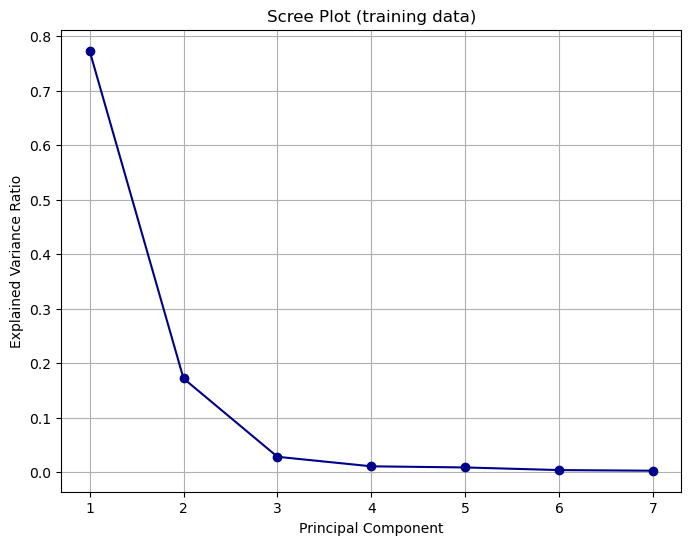

In [133]:
# Fit PCA on all components
pca_full = PCA().fit(X_tr_scaled) # n_components default = n_features (7)

X_tr_scaled_pca7  = pca_full.transform(X_tr_scaled) # NOT a final model only exploratory!
X_val_scaled_pca7 = pca_full.transform(X_val_scaled)

# Scree plot of explained variance ratio
plt.figure(figsize=(8,6))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1), 
    pca_full.explained_variance_ratio_, 
    'o-', color='darkblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (training data)')
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

----

#### Task 6: PCA plots with 2 principal components 

In [134]:
# PCA with 2PC
pca2 = PCA(n_components=2)
X_tr_scaled_pca2 = pca2.fit_transform(X_tr_scaled) # NOT a final model only visualization!
X_val_scaled_pca2 = pca2.transform(X_val_scaled)

print(
    f"✅ Training and validation sets have been scaled and PCA-transformed: "
    f"{X_tr_scaled_pca2.shape} train, {X_val_scaled_pca2.shape} validation.")

# The PCA coordinates (2D) are shared across all visualizations (RBF, Polynomial).
# These are computed once and reused, since PCA is independent of the SVM kernel.

✅ Training and validation sets have been scaled and PCA-transformed: (157, 2) train, (40, 2) validation.


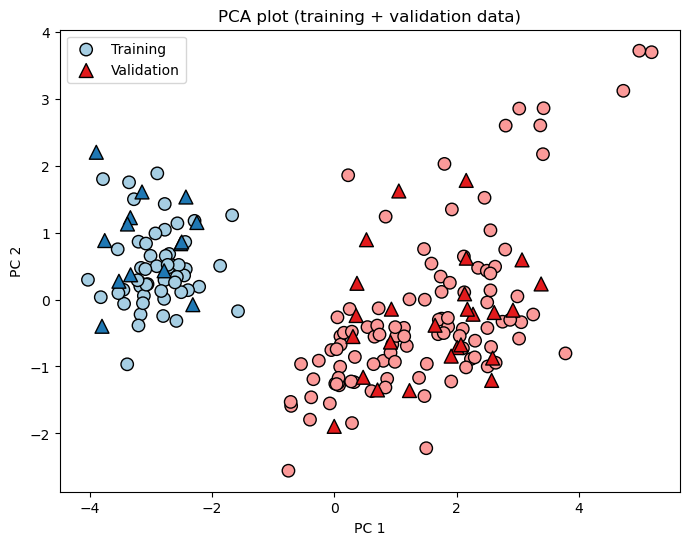

In [135]:
plt.figure(figsize=(8,6))

# Define color palettes
cmap_tr = ListedColormap([COLORS["train_0"], COLORS["train_1"]])
cmap_val   = ListedColormap([COLORS["val_0"], COLORS["val_1"]])

# Training data
plt.scatter(
    X_tr_scaled_pca2[:, 0], X_tr_scaled_pca2[:, 1],
    c=y_tr, cmap=cmap_tr, edgecolors='k', s=POINT_SIZES["train"], label='Training'
)

# Validation data
plt.scatter(
    X_val_scaled_pca2[:, 0], X_val_scaled_pca2[:, 1],
    c=y_val, cmap=cmap_val, marker=MARKERS["val"], edgecolors='k', s=POINT_SIZES["val"], label='Validation'
)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA plot (training + validation data)')
plt.legend()
plt.show()


----
----

#### **SVM with RBF kernel**

#### Task 7: RBF kernel: PCA transformation and ROC curves

(a) withou PCA: X_tr_scaled, X_val_scaled
(b) PCA with 2 PCs: X_tr_scaled_pca2, X_val_scaled_pca2 
(c) PCA with 7 PC: X_tr_scaled_pca7, X_val_scaled_pca7 

In [136]:
datasets_rbf = {
    "No PCA": (X_tr_scaled, X_val_scaled),
    "PCA (2 comp)": (X_tr_scaled_pca2, X_val_scaled_pca2),
    "PCA (all comp)": (X_tr_scaled_pca7, X_val_scaled_pca7)
}

results = {}

for name, (Xtr, Xval) in datasets_rbf.items():
    clf = SVC(kernel="rbf", probability=True, random_state=42)
    clf.fit(Xtr, y_tr)                                              # <- exploratory fit for ROC, NOT a final model, only evaluation!

    y_val_scores = clf.decision_function(Xval)
    fpr, tpr, _ = roc_curve(y_val, y_val_scores)
    roc_auc = auc(fpr, tpr)

    results[name] = (fpr, tpr, roc_auc)


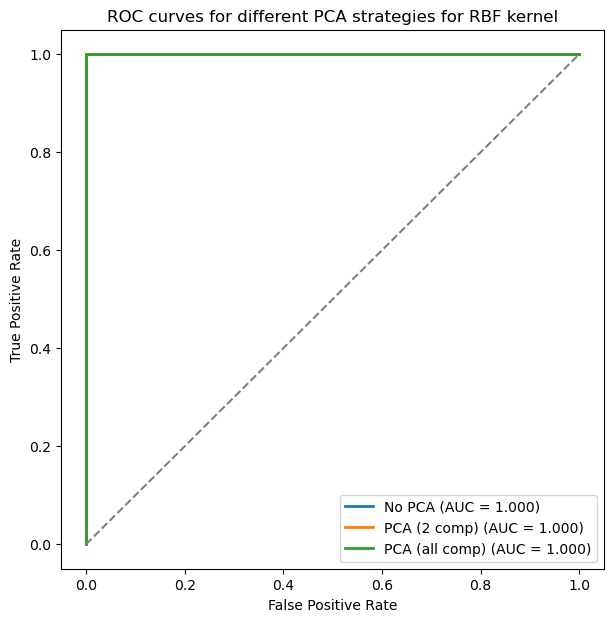

In [137]:
plt.figure(figsize=(7, 7))
for name, (fpr, tpr, roc_auc) in results.items():
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for different PCA strategies for RBF kernel")
plt.legend(loc="lower right")
plt.show()


----

#### Task 8: RBF kernel: Validation curves (check for overfitting)

We evaluate SVM capacity by sweeping C and γ with a pipeline that standardizes
features and (optionally) applies PCA(2). Training vs. validation (CV) gaps indicate
overfitting; low/close curves indicate underfitting; high/close curves indicate a good trade‑off.

Pipeline with PCA(2) + SVM
Purpose: To build the actual classification model, not fitted yet


In [138]:
# Cross-validation settings used throughout the notebook
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "balanced_accuracy"

In [139]:
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),  
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)),
])

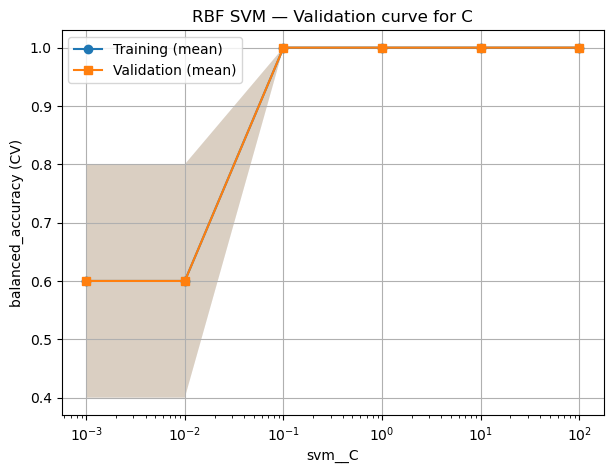

🔍 Mean training scores: [0.6 0.6 1.  1.  1.  1. ]
🔍 Mean validation scores: [0.6 0.6 1.  1.  1.  1. ]
📉 Differences (train - val): [0. 0. 0. 0. 0. 0.]
Best svm__C by validation score: 0.1 — score = 1.00
Most balanced svm__C (train - val): 0.001 — diff = 0.00


{'train_scores': array([[0.5, 0.5, 1. , 0.5, 0.5],
        [0.5, 0.5, 1. , 0.5, 0.5],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ]]),
 'val_scores': array([[0.5, 0.5, 1. , 0.5, 0.5],
        [0.5, 0.5, 1. , 0.5, 0.5],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ],
        [1. , 1. , 1. , 1. , 1. ]]),
 'train_mean': array([0.6, 0.6, 1. , 1. , 1. , 1. ]),
 'val_mean': array([0.6, 0.6, 1. , 1. , 1. , 1. ]),
 'train_std': array([0.2, 0.2, 0. , 0. , 0. , 0. ]),
 'val_std': array([0.2, 0.2, 0. , 0. , 0. , 0. ])}

In [140]:
# C 
plot_validation_curve(
    estimator=pipe_rbf,
    X=X_tr, y=y_tr,
    param_name="svm__C",
    param_range=[0.001, 0.01, 0.1, 1, 10, 100],
    cv=cv, scoring=scoring, xscale="log",
    title="RBF SVM — Validation curve for C"
)

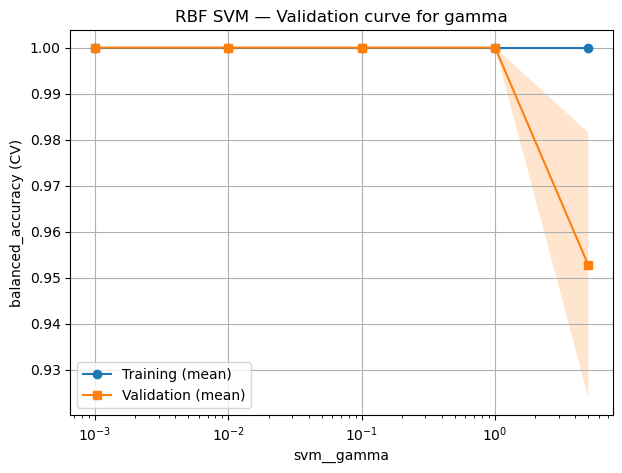

🔍 Mean training scores: [1. 1. 1. 1. 1.]
🔍 Mean validation scores: [1.   1.   1.   1.   0.95]
📉 Differences (train - val): [0.   0.   0.   0.   0.05]
Best svm__gamma by validation score: 0.001 — score = 1.00
Most balanced svm__gamma (train - val): 0.001 — diff = 0.00


{'train_scores': array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]]),
 'val_scores': array([[1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [0.90909091, 0.95454545, 1.        , 0.95      , 0.95      ]]),
 'train_mean': array([1., 1., 1., 1., 1.]),
 'val_mean': array([1.        , 1.        , 1.        , 1.        , 0.95272727]),
 'train_std': array([0., 0., 0., 0., 0.]),
 'val_std': array([0.        , 0.        , 0.        , 0.        , 0.02883409])}

In [141]:

# gamma
plot_validation_curve(
    estimator=pipe_rbf,
    X=X_tr, y=y_tr,
    param_name="svm__gamma",
    param_range=[0.001, 0.01, 0.1, 1, 5],
    cv=cv, scoring=scoring, xscale="log",
    title="RBF SVM — Validation curve for gamma"
)

### What these validation curves show

Validation curves were computed using 5‑fold stratified cross-validation on the training split.

For the RBF SVM:
- The training and validation scores are consistently high and overlapping for `C ≥ 0.1`, suggesting no overfitting in this range.
- For small values of `C`, model performance drops significantly (balanced accuracy ~0.6).
- For `gamma`, validation performance remains strong up to `γ = 1.0`, but starts to decline for larger values, indicating signs of overfitting at `γ = 5`.

These results support selecting `C ≥ 0.1` and `γ ≤ 1.0` for final tuning.  
Final hyperparameters will be optimized via `GridSearchCV` and evaluated on the held‑out validation set (20%).

----

#### Task 9: RBF kernel: Selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)

In this step we re-run the entire preprocessing **inside** the model-selection loop:
`StandardScaler → PCA(n_components=2) → SVM`.  
Doing scaling and PCA **inside** `Pipeline` ensures that in each CV fold the PCA
axes and scaling parameters are fit **only on the training portion of that fold**,
preventing data leakage.  
Although we previously explored the data with external scaling/PCA (for scree plot
and visualization), those results are not used here — GridSearchCV re-fits everything
from scratch in a methodologically clean way.

We optimize SVM hyperparameters using stratified 5-fold CV. As the primary score
you can use `balanced_accuracy` (robust to class imbalance) or, if minimizing false
negatives for the *poor* class is critical, `recall (pos_label=0)`.


In [142]:

param_grid_rbf = {
    "svm__C":     [0.001, 0.01, 0.1, 1, 10],
    "svm__gamma": [0.001, 0.01, 0.1, 1.0, 10]
}

gs_rbf = GridSearchCV(
    estimator=pipe_rbf,
    param_grid=param_grid_rbf,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
)

# ← true model training happens here. This is the actual training step (the only one that matters for final model)
gs_rbf.fit(X_tr, y_tr)

# Purpose:
# - To retrieve the best-performing pipeline (with optimized hyperparameters)
# - This pipeline includes the fitted scaler, PCA(2), and SVM (RBF kernel)
# 
# This is the model to use for:
# - prediction on new data
# - visualization (e.g. decision boundary)

best_svm_rbf = gs_rbf.best_estimator_
print("🔹 Best parameters (RBF kernel):", gs_rbf.best_params_)

# RBF validation
y_val_pred_rbf = best_svm_rbf.predict(X_val)
y_val_scores_rbf = best_svm_rbf.decision_function(X_val)

print("🔹 Balanced accuracy (val):", f"{balanced_accuracy_score(y_val, y_val_pred_rbf):.2f}")
print("\n🔹 Classification report for RBF model (validation set):")
print(classification_report(y_val, y_val_pred_rbf, target_names=["poor(0)","good(1)"]))


fpr_rbf, tpr_rbf, _ = roc_curve(y_val, y_val_scores_rbf)

cv_scores_rbf = cross_val_score(
    best_svm_rbf,
    X_tr,
    y_tr,
    cv=5,
    scoring="roc_auc"
    )

print("🔹 5-fold CV AUC scores:", cv_scores_rbf)
print("🔹 AUC (RBF, val):", f"{auc(fpr_rbf,tpr_rbf):.2f}")
print(f"🔹 Mean CV AUC: {cv_scores_rbf.mean():.1f} ± {cv_scores_rbf.std():.2f}")
print("🔹 Inner CV best balanced accuracy (GridSearchCV) for RBF kernel:", f"{gs_rbf.best_score_:.2f}")


🔹 Best parameters (RBF kernel): {'svm__C': 0.1, 'svm__gamma': 0.01}
🔹 Balanced accuracy (val): 1.00

🔹 Classification report for RBF model (validation set):
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00        26
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

🔹 5-fold CV AUC scores: [1. 1. 1. 1. 1.]
🔹 AUC (RBF, val): 1.00
🔹 Mean CV AUC: 1.0 ± 0.00
🔹 Inner CV best balanced accuracy (GridSearchCV) for RBF kernel: 1.00


🔹Confusion matrix:


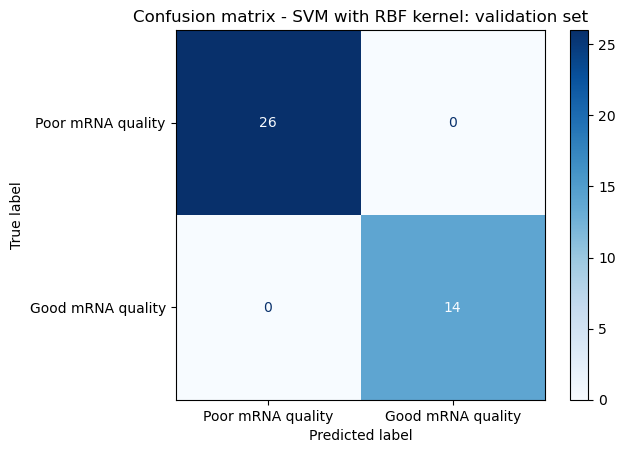

In [143]:
# Confusion matrix using validation data
print("🔹Confusion matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_val,  # Actual values
    y_val_pred_rbf,  # Predicted values
    display_labels=["Poor mRNA quality", "Good mRNA quality"],   
    cmap='Blues'  # Color map
)
plt.title('Confusion matrix - SVM with RBF kernel: validation set')
plt.show()

Final hyperparameters
were selected via GridSearchCV and verified on the held‑out validation set (20%).

----

#### Task 10: RBF kernel: Support vectors

In [144]:
#Extract the fitted SVM classifier from the pipeline
svm_rbf = best_svm_rbf.named_steps["svm"] 
n_per_class_rbf = svm_rbf.n_support_
total_sv_rbf = n_per_class_rbf.sum()
ratio_rbf = total_sv_rbf / len(X_tr)      

print("Support vectors per class (RBF):", n_per_class_rbf)
print("Total SV:", total_sv_rbf)
print(f"Ratio SV / training samples (X_tr): {ratio_rbf:.2f}")

Support vectors per class (RBF): [76 39]
Total SV: 115
Ratio SV / training samples (X_tr): 0.73


----

#### Task 11: RBF kernel: Visualisation of the decision boundary using 2D PCA


Scatter plots show only the **measured data points** in the 2D PCA space, but they do not reveal **how the model separates the classes** in regions where no samples exist.  

To visualize the **decision boundary of the SVM**, we generate a **dense grid of points** that covers the whole PCA-transformed space.  
Each grid point is then passed through the trained pipeline (scaling → PCA → SVM), and the predicted class is used to color the background.  

This way we can see not only the samples, but also the **decision regions** and the **boundary line** where the SVM changes its prediction from one class to the other.


In [145]:
# ============================================
# PART 1 — Define grid over 2D PCA space
# Purpose: Create a mesh that covers the entire PCA space
# Used for evaluating model predictions (decision regions)
# ============================================

# Get the PCA coordinates for your points (for plotting). I already have X_tr_scaled_pca2 computed with these exact fitted objects
x_min, x_max = X_tr_scaled_pca2[:, 0].min() - 1.0, X_tr_scaled_pca2[:, 0].max() + 1.0
y_min, y_max =X_tr_scaled_pca2[:, 1].min() - 1.0, X_tr_scaled_pca2[:, 1].max() + 1.0

# Build a dense grid in PCA space: We’ll cover the whole region where the points are
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
grid_pca_rbf = np.c_[xx.ravel(), yy.ravel()]   # shape (300*300, 2)


In [146]:

# ============================================
# PART 2 — Predict model output over grid
# Purpose: Predict decision regions in PCA space
# This will be used to color the background
# ============================================

Z = svm_rbf.predict(grid_pca_rbf).reshape(xx.shape)

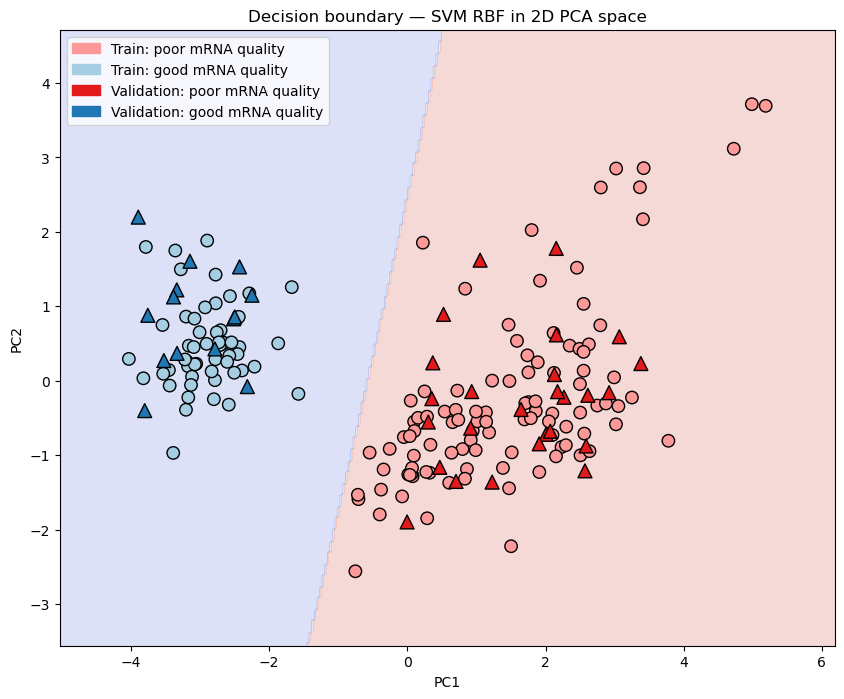

In [147]:
# ============================================
# PART 3 — Plot: Decision boundary + training + validation
# Purpose: Visualize background (decision regions) and real data
# ============================================

# Decision boundary plot in 2D PCA space
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r)

# Training data scatter plot
plt.scatter(X_tr_scaled_pca2[:,0],  X_tr_scaled_pca2[:,1],  c=y_tr,  cmap=cmap_tr, marker=MARKERS["train"], edgecolors='k', s=POINT_SIZES["train"],  label='Training')
# Validation data scatter plot
plt.scatter(X_val_scaled_pca2[:,0], X_val_scaled_pca2[:,1], c=y_val, cmap=cmap_val, marker=MARKERS["val"], edgecolors='k', s=POINT_SIZES["val"], label='Validation')

# Legend patches
patch0_tr = mpatches.Patch(color=COLORS["train_0"], label='Train: poor mRNA quality')
patch1_tr = mpatches.Patch(color=COLORS["train_1"], label='Train: good mRNA quality')
patch0_va = mpatches.Patch(color=COLORS["val_0"], label='Validation: poor mRNA quality')
patch1_va = mpatches.Patch(color=COLORS["val_1"], label='Validation: good mRNA quality')
plt.legend(handles=[patch0_tr, patch1_tr, patch0_va, patch1_va], loc='upper left')

plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Decision boundary — SVM RBF in 2D PCA space')
plt.show()


'best_svm_rbf' is a complete pipeline (scaler + PCA + SVM).

----
----

#### **SVM with polynomial kernel**

We mirror the RBF workflow: (i) validation curves for capacity control (C, degree, coef0, γ),
(ii) grid search with stratified CV using balanced accuracy, (iii) evaluation on the 20% validation
split, and (iv) support‑vector count and decision‑boundary visualization in the PCA(2) space.

#### Task 12: Polynomial kernel: PCA transformation and ROC

In [148]:
datasets_poly = {
    "No PCA": (X_tr_scaled, X_val_scaled),
    "PCA (2 comp)": (X_tr_scaled_pca2, X_val_scaled_pca2),
    "PCA (all comp)": (X_tr_scaled_pca7, X_val_scaled_pca7),
}

results_poly = {}

for name, (Xtr, Xval) in datasets_poly.items():
    clf = SVC(kernel="poly", probability=True, class_weight="balanced", random_state=42)
    clf.fit(Xtr, y_tr)

    y_val_scores = clf.decision_function(Xval)
    fpr, tpr, _ = roc_curve(y_val, y_val_scores)
    roc_auc = auc(fpr, tpr)

    results_poly[name] = (fpr, tpr, roc_auc)


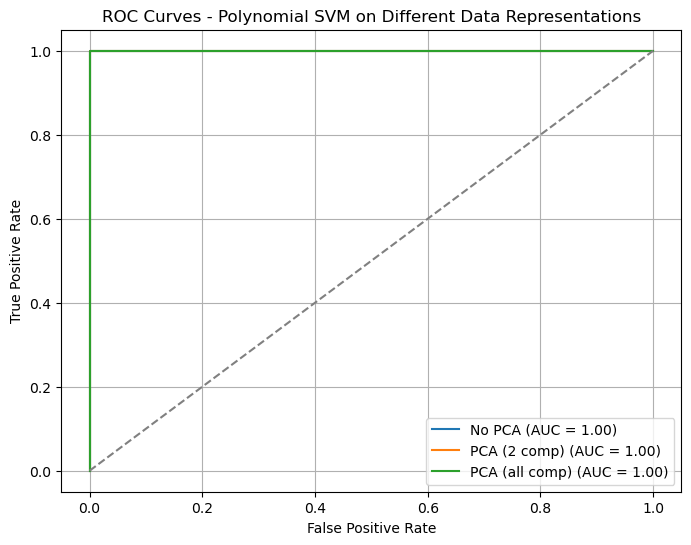

In [149]:
plt.figure(figsize=(8, 6))

for name, (fpr, tpr, auc_score) in results_poly.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Polynomial SVM on Different Data Representations")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


----

#### Task 13: Polynomial kernel: Validation curves (check for overfitting)

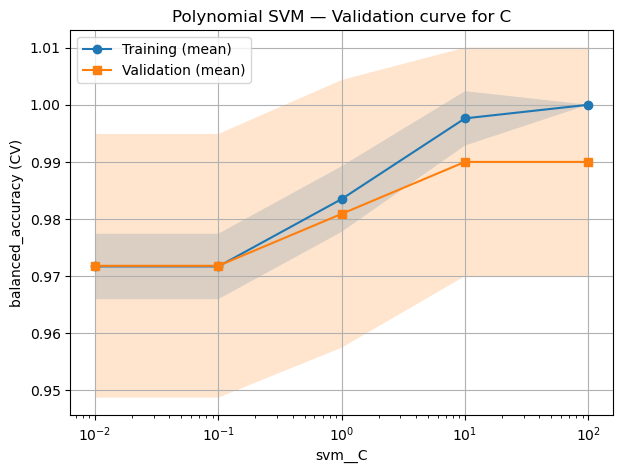

🔍 Mean training scores: [0.97 0.97 0.98 1.   1.  ]
🔍 Mean validation scores: [0.97 0.97 0.98 0.99 0.99]
📉 Differences (train - val): [-0.   -0.    0.    0.01  0.01]
Best svm__C by validation score: 10 — score = 0.99
Most balanced svm__C (train - val): 0.01 — diff = -0.00


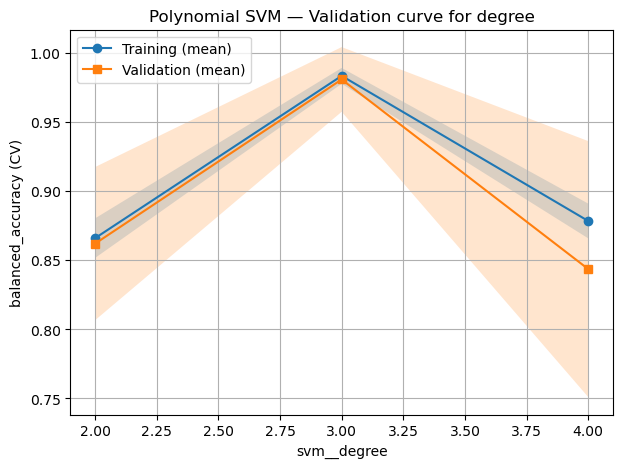

🔍 Mean training scores: [0.87 0.98 0.88]
🔍 Mean validation scores: [0.86 0.98 0.84]
📉 Differences (train - val): [0.   0.   0.03]
Best svm__degree by validation score: 3 — score = 0.98
Most balanced svm__degree (train - val): 3 — diff = 0.00


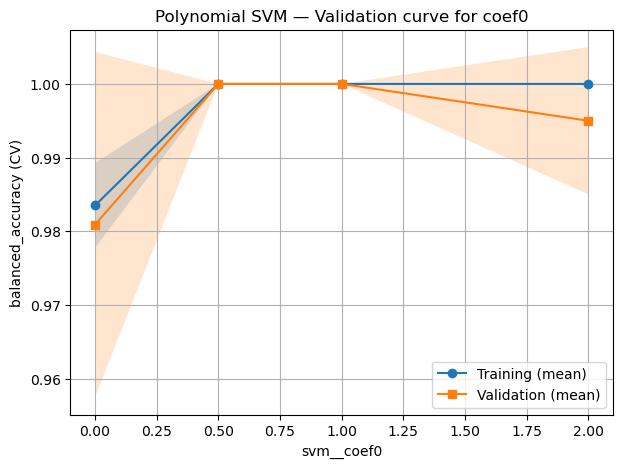

🔍 Mean training scores: [0.98 1.   1.   1.  ]
🔍 Mean validation scores: [0.98 1.   1.   0.99]
📉 Differences (train - val): [0.   0.   0.   0.01]
Best svm__coef0 by validation score: 0.5 — score = 1.00
Most balanced svm__coef0 (train - val): 0.5 — diff = 0.00


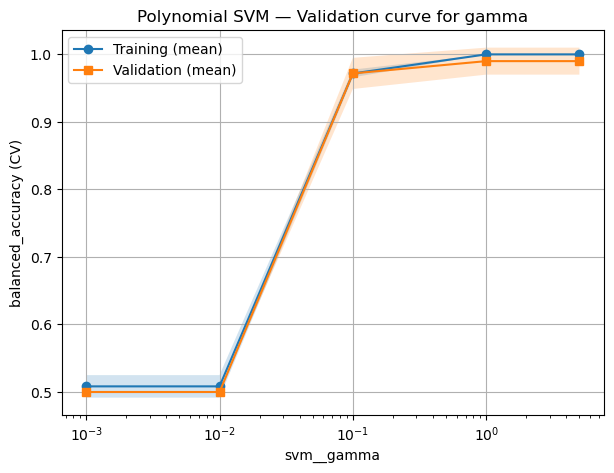

🔍 Mean training scores: [0.51 0.51 0.97 1.   1.  ]
🔍 Mean validation scores: [0.5  0.5  0.97 0.99 0.99]
📉 Differences (train - val): [ 0.01  0.01 -0.    0.01  0.01]
Best svm__gamma by validation score: 1.0 — score = 0.99
Most balanced svm__gamma (train - val): 0.1 — diff = -0.00


{'train_scores': array([[0.5       , 0.5       , 0.54166667, 0.5       , 0.5       ],
        [0.5       , 0.5       , 0.54166667, 0.5       , 0.5       ],
        [0.97619048, 0.97619048, 0.96428571, 0.96511628, 0.97674419],
        [1.        , 1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'val_scores': array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
        [0.95454545, 0.95454545, 1.        , 1.        , 0.95      ],
        [1.        , 1.        , 1.        , 1.        , 0.95      ],
        [1.        , 1.        , 1.        , 1.        , 0.95      ]]),
 'train_mean': array([0.50833333, 0.50833333, 0.97170543, 1.        , 1.        ]),
 'val_mean': array([0.5       , 0.5       , 0.97181818, 0.99      , 0.99      ]),
 'train_std': array([0.01666667, 0.01666667, 0.00572869, 0.        , 0.        ]),
 'val_std': array

In [150]:
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)), 
    ("svm", SVC(kernel="poly", probability=True, class_weight="balanced", random_state=42)),
])

plot_validation_curve(
    estimator=pipe_poly,
    X=X_tr, y=y_tr,
    param_name="svm__C",
    param_range=[0.01, 0.1, 1, 10, 100],
    cv=cv, scoring=scoring,
    xscale="log",
    title="Polynomial SVM — Validation curve for C"
)

plot_validation_curve(
    estimator=pipe_poly,
    X=X_tr, y=y_tr,
    param_name="svm__degree",
    param_range=[2, 3, 4],
    cv=cv, scoring=scoring,
    xscale=None,
    title="Polynomial SVM — Validation curve for degree"
)

plot_validation_curve(
    estimator=pipe_poly,
    X=X_tr, y=y_tr,
    param_name="svm__coef0",
    param_range=[0.0, 0.5, 1.0, 2.0],
    cv=cv, scoring=scoring,
    xscale=None,
    title="Polynomial SVM — Validation curve for coef0"
)

plot_validation_curve(
    estimator=pipe_poly,
    X=X_tr, y=y_tr,
    param_name="svm__gamma",
    param_range=np.array([0.001, 0.01, 0.1, 1, 5]),
    cv=cv, scoring=scoring,
    xscale="log",
    title="Polynomial SVM — Validation curve for gamma"
)


----

#### Task 14: Polynomial kernel: Selecting optimal hyperparameters with cross-validation (Pipeline + GridSearchCV)

In [151]:
pipe_poly = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)), 
    ("svm", SVC(kernel="poly", probability=True, class_weight="balanced", random_state=42)),
])

# grid 
param_grid_poly = {
    "svm__C":     [0.1, 1, 10, 100],
    "svm__degree":[2, 3],         
    "svm__coef0": [0.0, 0.5, 1.0],
    "svm__gamma": [0.01, 0.1, 1.0],
}

# GridSearchCV
gs_poly = GridSearchCV(
    estimator=pipe_poly,
    param_grid=param_grid_poly,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    refit=True,
)
gs_poly.fit(X_tr, y_tr)


#FINAL MODEL with whole pipeline
best_svm_poly = gs_poly.best_estimator_
print("🔹 Best parameters (Polynomial kernel):", gs_poly.best_params_)


y_val_pred_poly = best_svm_poly.predict(X_val)
y_val_scores_poly = best_svm_poly.decision_function(X_val)

ba_poly = balanced_accuracy_score(y_val, y_val_pred_poly)
print("🔹 Balanced accuracy (val):", f"{ba_poly:.2f}")

print("\n🔹 Classification report (val):")
print(classification_report(y_val, y_val_pred_poly, target_names=["poor(0)","good(1)"]))

cv_scores_poly = cross_val_score(
    best_svm_poly,
    X_tr,     # RAW data (7 features)
    y_tr,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("🔹 5-fold CV AUC scores:", cv_scores_poly)
fpr_poly, tpr_poly, _ = roc_curve(y_val, y_val_scores_poly)
print("🔹 AUC (val):", f"{auc(fpr_poly, tpr_poly):.2f}")


print(f"🔹 Mean CV AUC: {cv_scores_poly.mean():.1f} ± {cv_scores_poly.std():.2f}")
print("🔹  Inner CV best balanced accuracy (average across folds) for  for polynomial kernel:", f"{gs_poly.best_score_:.2f}")




🔹 Best parameters (Polynomial kernel): {'svm__C': 0.1, 'svm__coef0': 0.5, 'svm__degree': 2, 'svm__gamma': 0.1}
🔹 Balanced accuracy (val): 1.00

🔹 Classification report (val):
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00        26
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

🔹 5-fold CV AUC scores: [1. 1. 1. 1. 1.]
🔹 AUC (val): 1.00
🔹 Mean CV AUC: 1.0 ± 0.00
🔹  Inner CV best balanced accuracy (average across folds) for  for polynomial kernel: 1.00


🔹 Confusion matrix (validation):


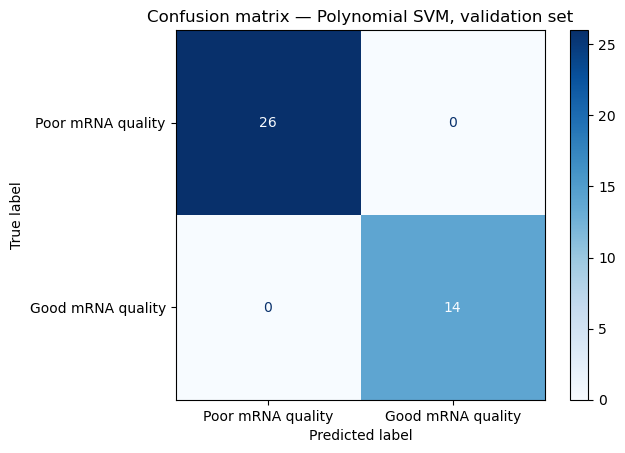

In [152]:
print("🔹 Confusion matrix (validation):")
ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred_poly,
    display_labels=["Poor mRNA quality", "Good mRNA quality"],
    cmap="Blues"
)
plt.title("Confusion matrix — Polynomial SVM, validation set")
plt.show()

----

#### Task 15: Polynomial kernel: Support vectors

In [153]:
svm_poly = best_svm_poly.named_steps["svm"]

n_per_class_poly = svm_poly.n_support_

total_sv_poly = n_per_class_poly.sum()

ratio_poly = total_sv_poly / len(X_tr)

print("Support vectors per class (Polynomial):", n_per_class_poly)
print("Total support vectors (Polynomial):", total_sv_poly)
print(f"Ratio (support vectors / training samples): {ratio_poly:.2f}")

Support vectors per class (Polynomial): [25 12]
Total support vectors (Polynomial): 37
Ratio (support vectors / training samples): 0.24


----

#### Task 16: Polynomial kernel: Visualisation of the decision boundary using 2D PCA

In [154]:
x_min, x_max = X_tr_scaled_pca2[:,0].min() - 1.0, X_tr_scaled_pca2[:,0].max() + 1.0
y_min, y_max = X_tr_scaled_pca2[:,1].min() - 1.0, X_tr_scaled_pca2[:,1].max() + 1.0

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid_pca = np.c_[xx.ravel(), yy.ravel()]

# Predict directly using SVM model
Z = svm_poly.predict(grid_pca).reshape(xx.shape)


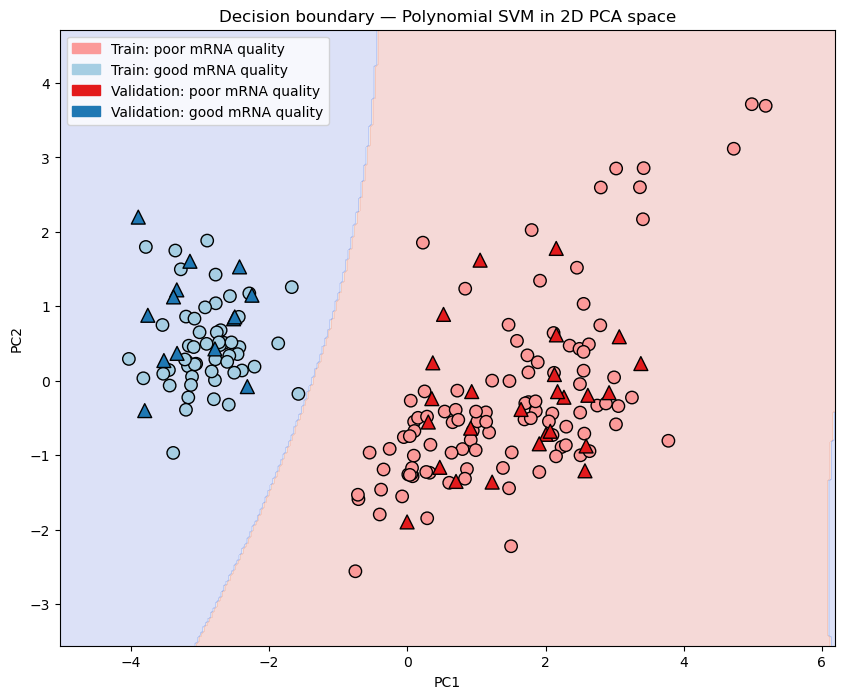

In [155]:
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm_r)

# Training data scatter plot
plt.scatter(X_tr_scaled_pca2[:,0],  X_tr_scaled_pca2[:,1],  c=y_tr,  cmap=cmap_tr, marker=MARKERS["train"], edgecolors='k', s=POINT_SIZES["train"],  label='Training')
# Validation data scatter plot
plt.scatter(X_val_scaled_pca2[:,0], X_val_scaled_pca2[:,1], c=y_val, cmap=cmap_val, marker=MARKERS["val"], edgecolors='k', s=POINT_SIZES["val"], label='Validation')

plt.legend(handles=[patch0_tr, patch1_tr, patch0_va, patch1_va], loc='upper left')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Decision boundary — Polynomial SVM in 2D PCA space')
plt.show()


----
----

#### **Building the Final SVM pipeline**

#### Task 17: Selection of the best kernel for SVM

RBF vs Polynomial kernel, on 157 training samples

| Model | Balanced Accuracy (val) | AUC (val) | # Support Vectors | SV Ratio (vs. training set) |
|-------|--------------------------|-----------|--------------------|-----------------------------|
| RBF   | 1.00                     | 1.00      | 115                | 0.73                        |
| Poly  | 1.00                     | 1.00      | 37                 | 0.24                        |

✅ Both RBF and polynomial kernels achieved perfect separation (AUC = 1.0). However, the polynomial kernel required fewer support vectors, indicating a simpler decision boundary. This suggested better potential for generalization, and therefore it was selected for further validation.


----

#### Task 18: Final model refitting on the full training set (without 23 holdouts)

This step will **train the final version of the SVM model** on the complete training dataset with 197 samples.

⚠️ **MODEL VERSIONING ENABLED**

- If you have changed any part of the **data**, **feature processing**, or **model parameters**, a new version of the model should be saved to preserve reproducibility.
- The code will automatically check the `models/versions/` folder for any previously saved versions.
- You will see information about the **latest saved model version** (e.g., `final_pipeline_prob_v3_2025-09-04.joblib`).
- You will be **prompted to confirm** whether a new version should be saved using an interactive toggle (✅ yes / ❌ no).
- If you confirm, a new file will be created (e.g., `final_pipeline_prob_v4_2025-09-04.joblib`), and stored in `models/versions/`.

📌 The **active model used by applications** remains in folder MODELS unless updated manually.

This versioned saving mechanism ensures previous models are not accidentally overwritten and allows you to maintain a clean, traceable history of all trained versions.

In [156]:
# ============================================
# FINAL MODEL TRAINING — POLYNOMIAL KERNEL
# Purpose:
# - To train the final SVM model with polynomial kernel
# - Uses the full available training data (train + validation)
# - Parameters were pre-selected from GridSearchCV
# ============================================

In [157]:
final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2)),
    ("model", SVC(
        kernel="poly",
        C=0.1,
        degree=2,
        coef0=0.5,
        gamma=0.1,
        class_weight="balanced",
        probability=True,
        random_state=42
    ))
])

In [158]:
X_train_full = pd.concat([X_tr, X_val])
y_train_full = pd.concat([y_tr, y_val])

In [159]:
# Fit the model on the full training set
final_pipeline.fit(X_train_full, y_train_full)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('model',
                 SVC(C=0.1, class_weight='balanced', coef0=0.5, degree=2,
                     gamma=0.1, kernel='poly', probability=True,
                     random_state=42))])

In [160]:

base_name = "final_pipeline_prob"
today = datetime.today().strftime("%Y-%m-%d")

existing_versions = sorted(VERSIONS_DIR.glob(f"{base_name}_v*_*.joblib"))
new_version = len(existing_versions) + 1 if existing_versions else 1
latest_msg = f"🕒 Previous saved version: {existing_versions[-1].name}" if existing_versions else "ℹ️ No previous versioned models found."
print(latest_msg)

active_model_path = MODELS_DIR / f"{base_name}.joblib"
new_filename = f"{base_name}_v{new_version}_{today}.joblib"

print("\n⚠️ You are about to save a VERSIONED model.")
print(f"→ It will be saved to: versions/{new_filename}")

if MODEL_PATH.exists():
    print(f"ℹ️ The ACTIVE model used by apps is still: {MODEL_PATH.name}")
else:
    print(f"⚠️ No active model found in folder models. Please add the correct model there.")

print("Please confirm whether to save the new version:")


save_widget = widgets.ToggleButtons(
    options=[("⬜ choose", "none"), ("✅ yes", "yes"), ("❌ no", "no")],
    description="Save versioned model?",
    value="none",
    button_style='info',
    style={'description_width': 'initial'}
)

output = widgets.Output()
display(save_widget, output)

save_widget.observe(
    lambda change: (
        output.clear_output(),
        output.append_stdout(
            f"✅ Versioned model saved as: {new_filename}\n📌 Reminder: Active model is still: {MODEL_PATH.name}"
            if change["new"] == "yes" and "final_pipeline" in globals()
            else "⚠️ Model 'final_pipeline' not found. Please train it first."
            if change["new"] == "yes"
            else "❌ Model was not saved." if change["new"] == "no" else ""
        ),
        joblib.dump(final_pipeline, VERSIONS_DIR / new_filename)
        if change["new"] == "yes" and "final_pipeline" in globals()
        else None,
        setattr(save_widget, "disabled", True)
    ),
    names="value"
)

🕒 Previous saved version: final_pipeline_prob_v3_2025-09-05.joblib

⚠️ You are about to save a VERSIONED model.
→ It will be saved to: versions/final_pipeline_prob_v4_2025-09-12.joblib
ℹ️ The ACTIVE model used by apps is still: final_pipeline_prob_v3_2025-09-05.joblib
Please confirm whether to save the new version:


ToggleButtons(button_style='info', description='Save versioned model?', options=(('⬜ choose', 'none'), ('✅ yes…

Output()

----

#### Task 19: Final support vectors

In [161]:
scaler_final = final_pipeline.named_steps["scaler"]
pca_final    = final_pipeline.named_steps["pca"]
svm_final    = final_pipeline.named_steps["model"]


In [162]:
n_per_class_final = svm_final.n_support_
total_sv_final = n_per_class_final.sum()
ratio_final = total_sv_final / len(X_train_full)

print("🔹 Support vectors per class:", n_per_class_final)
print("🔹 Total support vectors:", total_sv_final)
print(f"🔹 Ratio SV / training samples: {ratio_final:.2f}")


🔹 Support vectors per class: [27 13]
🔹 Total support vectors: 40
🔹 Ratio SV / training samples: 0.20


The final model trained on the full dataset (n = 197) exhibits a lower support vector ratio compared to the model trained on the 80% training split.
This indicates a more stable and generalizable decision boundary, as the classifier can separate the two classes confidently with fewer critical points relative to the dataset size.

----

#### Task 20: Summary for final model training and saving


The final classifier was trained on the full development dataset (n = 197) using the selected polynomial kernel and optimal hyperparameters. This model includes the complete preprocessing pipeline — scaling, PCA transformation with 2 PCs, and the trained SVM classifier. 

The pipeline was saved as a reusable .joblib file under the name: final_pipeline_prob_v1_2025-09-04.joblib, and is currently stored and loaded from the main model directory: models/

A copy of the same versioned model is also archived in the version control folder: models/versions/but the active model used in this notebook is the one from models/.


----
----

# Support Vector Machine Part 2 – Model Testing

### 🧪 Evaluation on External Test Sets


Two external test sets were used to verify the generalizability of the final model:

- **Test1:** A set of 23 samples originally part of the full dataset (n=220), but excluded from the training/validation subset (n=197). These were processed at the same time as the training data.
  
- **Test2:** The same 23 RNA samples as in Test1, but reprocessed independently at a later time and on a different machine, using a fresh experimental setup. Although the biological material is identical, **cDNA synthesis, qPCR amplification, and data acquisition were repeated from scratch**, making this a true **technical replication** under altered conditions.

----

#### Task 1: Reloading the saved final model from joblib

Although the `pipeline` object might already exist in memory from earlier cells,
it is not guaranteed that it corresponds to the correct, final version of the model.

To ensure consistency, reproducibility, and to avoid accidental use of an outdated or intermediate version,
we explicitly reload the model from the saved `.joblib` file:  
**`final_pipeline_prob_v1_2025-09-04.joblib`**

This guarantees that:
- The test results are based on the exact saved model.
- The model matches the threshold calculated for this version.
- The notebook can be rerun from any cell and still work correctly.


In [163]:
reloaded_pipeline = joblib.load(MODEL_PATH)
print("✅ Model loaded from:", MODEL_PATH)

reloaded_model  = reloaded_pipeline.named_steps['model']
reloaded_scaler = reloaded_pipeline.named_steps['scaler']
reloaded_pca    = reloaded_pipeline.named_steps['pca']

✅ Model loaded from: c:\Users\UserPhD\OneDrive - Univerzita Karlova\spidia ČLÁNEK 2 obnoveno 2022\aplikace_predikce\models\final_pipeline_prob_v3_2025-09-05.joblib


----

#### Task 2: Data preprocessing - Train197, Test1 and Test2

In [164]:
# 📥 Load test datasets
train_197_df = pd.read_csv(DEV_DATA_PATH, index_col=0)
test_set1_df = pd.read_csv(TEST1_PATH, index_col=0)
test_set2_df = pd.read_csv(TEST2_PATH, index_col=0)

In [165]:
# Define feature matrix (X) and target vector (y) 
feature_cols = reloaded_scaler.feature_names_in_
X_test1       = test_set1_df[feature_cols]
X_test2       = test_set2_df[feature_cols]
X_train_197 = train_197_df[feature_cols]

y_train_197 = train_197_df["groups"].astype(int)
y_test1 = test_set1_df["groups"].astype(int)
y_test2 = test_set2_df["groups"].astype(int)

In [166]:

# Scale the feature data
X_train_197_scaled = reloaded_scaler.transform(X_train_197)
X_test1_scaled   = reloaded_scaler.transform(X_test1)
X_test2_scaled    = reloaded_scaler.transform(X_test2)

# Apply PCA transformation
X_train_197_scaled_pca = reloaded_pca.transform(X_train_197_scaled)
X_test1_scaled_pca   = reloaded_pca.transform(X_test1_scaled)
X_test2_scaled_pca    = reloaded_pca.transform(X_test2_scaled)

----

#### Task 3: Test1 and Test2 predictions

In [167]:
y_pred_test1 = reloaded_pipeline.predict(X_test1)
print("Classification report for test1")
print(classification_report(y_test1, y_pred_test1 , target_names=["poor(0)","good(1)"]))

y_pred_test2 = reloaded_pipeline.predict(X_test2)
print("Classification report for test2")
print(classification_report(y_test2, y_pred_test2 , target_names=["poor(0)","good(1)"]))


Classification report for test1
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00         9
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Classification report for test2
              precision    recall  f1-score   support

     poor(0)       1.00      1.00      1.00         9
     good(1)       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



----

#### Task 4: Visualize decision function score distribution

In [168]:
# Computing decision scores
scores_test1 = reloaded_pipeline.decision_function(X_test1)
scores_test2 = reloaded_pipeline.decision_function(X_test2)

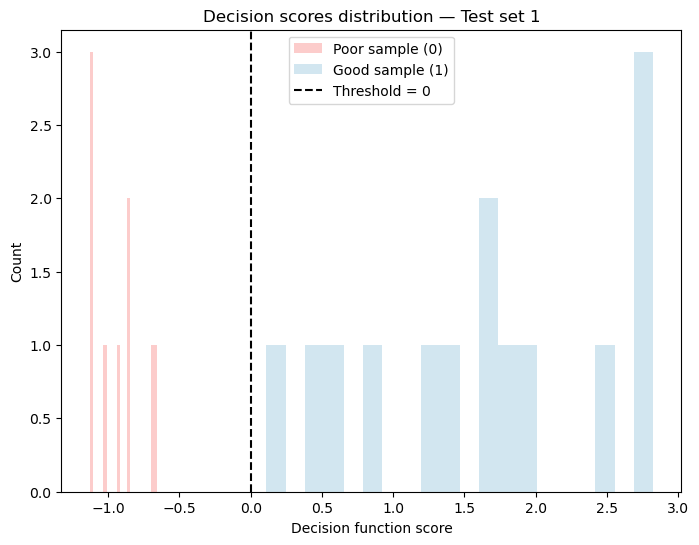

In [169]:
# TEST1

plt.figure(figsize=(8, 6))

# Plot histogram for class 1 (good)
# Note: if there are no samples of a class, np.array([]) will avoid errors.
scores_good_1 = np.array(scores_test1[y_test1 == 0])
scores_bad_1  = np.array(scores_test1[y_test1 == 1])

plt.hist(scores_good_1, bins=20, alpha=0.5, label="Poor sample (0)", color="#fb9a99")
plt.hist(scores_bad_1,  bins=20, alpha=0.5, label="Good sample (1)", color="#a6cee3")

# Default SVM decision threshold at 0
plt.axvline(0, linestyle="--", label="Threshold = 0", color="k")

plt.xlabel("Decision function score")
plt.ylabel("Count")
plt.title("Decision scores distribution — Test set 1")
plt.legend()
plt.show()


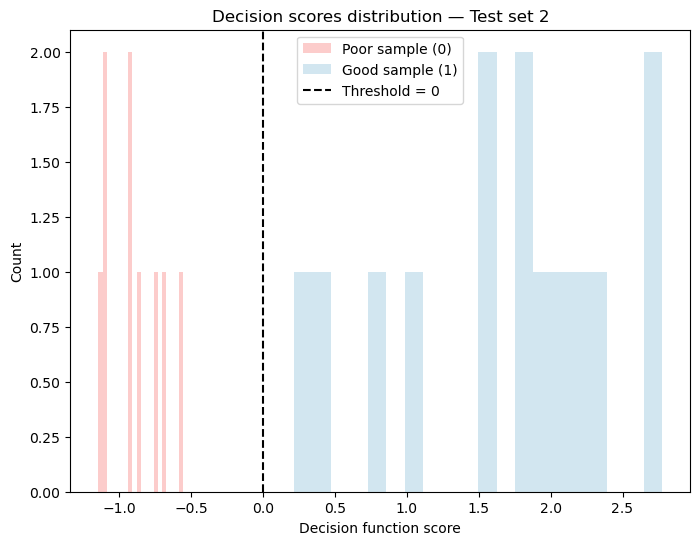

In [170]:
# TEST2

plt.figure(figsize=(8, 6))

# Plot histogram for class 0 (good)
# Note: if there are no samples of a class, np.array([]) will avoid errors.
scores_good_2 = np.array(scores_test2[y_test2 == 0])
scores_bad_2  = np.array(scores_test2[y_test2 == 1])

plt.hist(scores_good_2, bins=20, alpha=0.5, label="Poor sample (0)", color="#fb9a99")
plt.hist(scores_bad_2,  bins=20, alpha=0.5, label="Good sample (1)", color="#a6cee3")

# Default SVM decision threshold at 0
plt.axvline(0, linestyle="--", label="Threshold = 0", color="k")

plt.xlabel("Decision function score")
plt.ylabel("Count")
plt.title("Decision scores distribution — Test set 2")
plt.legend()
plt.show()



----

#### Task 5: Visualisation of decision function scores for test samples

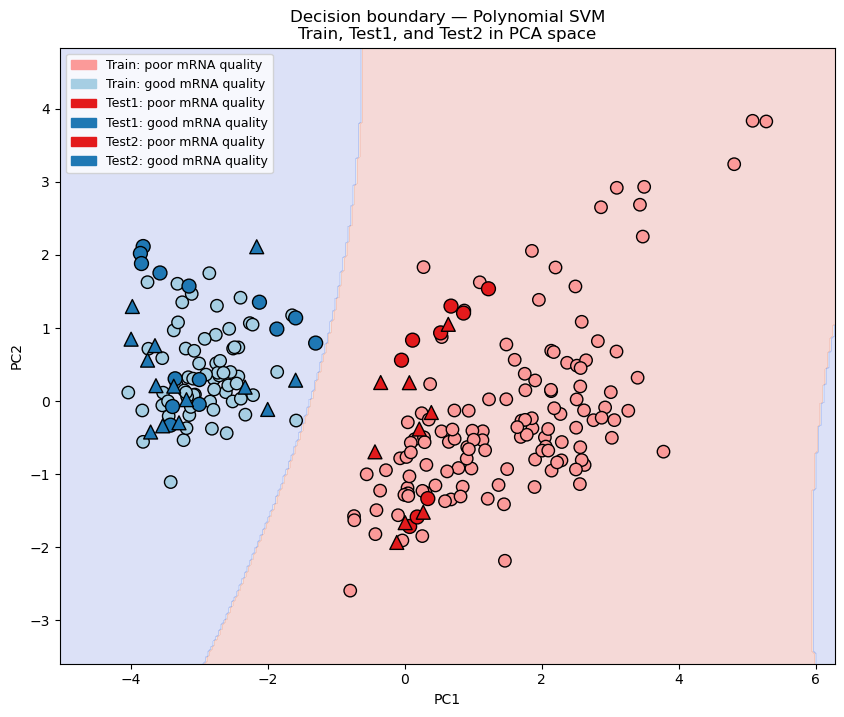

In [171]:

x_min, x_max = X_train_197_scaled_pca[:, 0].min() - 1.0, X_train_197_scaled_pca[:, 0].max() + 1.0
y_min, y_max = X_train_197_scaled_pca[:, 1].min() - 1.0, X_train_197_scaled_pca[:, 1].max() + 1.0

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid_pca_reloaded = np.c_[xx.ravel(), yy.ravel()]

Z_scores_reloaded = reloaded_model.decision_function(grid_pca_reloaded).reshape(xx.shape)
Z_reloaded = reloaded_model.predict(grid_pca_reloaded).reshape(xx.shape)


# Vykreslení
plt.figure(figsize=(10, 8))

# Decision boundary
plt.contourf(xx, yy, Z_reloaded, alpha=0.2, cmap=plt.cm.coolwarm_r)

# Training data
plt.scatter(
    X_train_197_scaled_pca[:, 0], X_train_197_scaled_pca[:, 1],
    c=y_train_197, cmap=cmap_tr, edgecolors='k', s=POINT_SIZES["train"], label='Training'
)

# Test1 data
plt.scatter(
    X_test1_scaled_pca[:, 0], X_test1_scaled_pca[:, 1],
    c=y_test1, cmap=cmap_val, marker='o', edgecolors='k', s=POINT_SIZES["val"], label='Test 1'
)

# Test2 data
plt.scatter(
    X_test2_scaled_pca[:, 0], X_test2_scaled_pca[:, 1],
    c=y_test2, cmap=cmap_val, marker='^', edgecolors='k', s=POINT_SIZES["val"], label='Test 2'
)

# Legenda pomocí Patch
patch0_tr = mpatches.Patch(color=COLORS["train_0"], label='Train: poor mRNA quality')
patch1_tr = mpatches.Patch(color=COLORS["train_1"], label='Train: good mRNA quality')
patch0_t1 = mpatches.Patch(color=COLORS["val_0"], label='Test1: poor mRNA quality')
patch1_t1 = mpatches.Patch(color=COLORS["val_1"], label='Test1: good mRNA quality')
patch0_t2 = mpatches.Patch(color=COLORS["val_0"], label='Test2: poor mRNA quality')
patch1_t2 = mpatches.Patch(color=COLORS["val_1"], label='Test2: good mRNA quality')

plt.legend(handles=[patch0_tr, patch1_tr, patch0_t1, patch1_t1, patch0_t2, patch1_t2],
           loc='upper left', fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Decision boundary — Polynomial SVM\nTrain, Test1, and Test2 in PCA space")
plt.show()

Threshold = 0

----

#### Task 6: Setting of "safe" threshold


The default decision boundary of an SVM classifier is set at score = 0, which equally separates both classes based on the training data.

However, in our use case, we aim to minimize the risk of misclassifying any good sample (class 0) as bad. This is especially important when applying the model to shifted or unknown data.

To achieve this, we define a custom `safe_threshold` by:

1. Combining all available labeled data (full training + test1 + test2)
2. Selecting only the samples labeled as "good" (class = 0)
3. Calculating their decision function scores using the trained model
4. Taking the **maximum score** observed among these good samples as the new threshold

This approach ensures that all known good samples fall below the `safe_threshold`. It moves the decision boundary slightly closer to the bad class, while still fully protecting the good samples.

This threshold can be used in future predictions as a conservative boundary that prioritizes **low false positive rate**, even at the cost of possibly missing some bad samples.


In [172]:
print(type(X_train_197_scaled_pca))
print(type(y_train_197))
print(type(reloaded_model))


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'sklearn.svm._classes.SVC'>


In [173]:
X_all_pca_reloaded = pd.concat([
    pd.DataFrame(X_train_197_scaled_pca),
    pd.DataFrame(X_test1_scaled_pca),
    pd.DataFrame(X_test2_scaled_pca)
], ignore_index=True)


y_all = pd.concat([
    y_train_197,
    y_test1,
    y_test2
], ignore_index=True)

X_bad = X_all_pca_reloaded[y_all == 0]

scores_bad = reloaded_model.decision_function(X_bad)

safe_threshold = scores_bad.max()

print(f"✅ Safe threshold (maximum decision score among 'poor' samples): {safe_threshold:.2f}")


✅ Safe threshold (maximum decision score among 'poor' samples): -0.56


----

#### Task 7: Visualization of the safe threshold

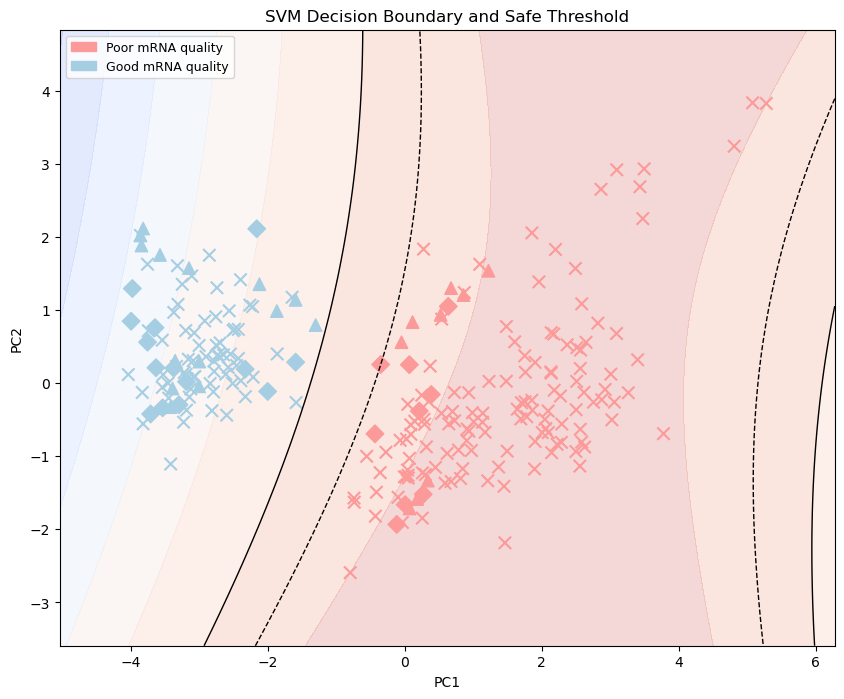

In [174]:
# Visualization
plt.figure(figsize=(10, 8))
plt.title("SVM Decision Boundary and Safe Threshold")

# Grid
x_min, x_max = X_train_197_scaled_pca[:, 0].min() - 1.0, X_train_197_scaled_pca[:, 0].max() + 1.0
y_min, y_max = X_train_197_scaled_pca[:, 1].min() - 1.0, X_train_197_scaled_pca[:, 1].max() + 1.0

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

grid_pca = np.c_[xx.ravel(), yy.ravel()]

# Decision function and prediction
Z_scores = reloaded_model.decision_function(grid_pca).reshape(xx.shape)
Z = reloaded_model.predict(grid_pca).reshape(xx.shape)

# Safe_threshold
levels = sorted([0, safe_threshold])


# 🧭 Decision boundary (line 0) amd  safe threshold (line safe_threshold)
plt.contour(xx, yy, Z_scores, levels=[0], colors='k', linewidths=1, linestyles='solid')
plt.contour(xx, yy, Z_scores, levels=[safe_threshold], colors='k', linewidths=1, linestyles='dashed')

# 🎨 Colourfull background
plt.contourf(xx, yy, Z_scores, alpha=0.2, cmap=plt.cm.coolwarm_r)


 # Scatter plot: training data
plt.scatter(
    X_train_197_scaled_pca[:, 0], X_train_197_scaled_pca[:, 1],
    c=y_train_197, cmap=cmap_tr, marker='x', s=POINT_SIZES["train"], label='Train'
)

# # Scatter plot: test 1
plt.scatter(
    X_test1_scaled_pca[:, 0], X_test1_scaled_pca[:, 1],
    c=y_test1, cmap=cmap_tr, marker='^', s=POINT_SIZES["train"], label='Test 1'
)

 # Scatter plot: test 2
plt.scatter(
    X_test2_scaled_pca[:, 0], X_test2_scaled_pca[:, 1],
    c=y_test2, cmap=cmap_tr, marker='D', s=POINT_SIZES["train"], label='Test 2'
)

# Legend patches
patch0_tr = mpatches.Patch(color=COLORS["train_0"], label='Poor mRNA quality')
patch1_tr = mpatches.Patch(color=COLORS["train_1"], label='Good mRNA quality')
plt.legend(handles=[patch0_tr, patch1_tr],
           loc='upper left', fontsize=9)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


----
----